## 전처리

### 데이터 불러오기

데이터 출처: https://www.kaggle.com/jrobischon/wikipedia-movie-plots/data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('wikipedia-movie-plots.zip')

In [3]:
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [4]:
plot = df['Plot']

In [8]:
plot[0]

"A bartender is working at a saloon, serving drinks to customers. After he fills a stereotypically Irish man's bucket with beer, Carrie Nation and her followers burst inside. They assault the Irish man, pulling his hat over his eyes and then dumping the beer over his head. The group then begin wrecking the bar, smashing the fixtures, mirrors, and breaking the cash register. The bartender then sprays seltzer water in Nation's face before a group of policemen appear and order everybody to leave.[1]"

In [5]:
plot.shape

(34886,)

### train test split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
plot_train, plot_test = train_test_split(plot, test_size=.2, random_state=1234)

### TDM

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
cv = CountVectorizer(stop_words='english', max_features=2000)

In [11]:
x_train = cv.fit_transform(plot_train)
x_test = cv.transform(plot_test)

## gensim을 이용한 LDA

### gensim 설치

아나콘다에서 설치

In [12]:
!conda install -y gensim

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\hyoun\Anaconda3

  added / updated specs:
    - gensim


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boto3-1.10.19              |             py_0          91 KB
    botocore-1.13.19           |             py_0         3.3 MB
    bz2file-0.98               |           py37_1          14 KB
    gensim-3.8.0               |   py37hf9181ef_0        18.4 MB
    jmespath-0.9.4             |             py_0          22 KB
    s3transfer-0.2.1           |           py37_0          99 KB
    smart_open-1.9.0           |             py_0          59 KB
    ------------------------------------------------------------
                                           Total:        22.0 MB

The following NEW packages will be INSTALLED:

  boto3              pkgs/main/noarch::boto3-1.10.19-py_0
  botocore    

아나콘다가 아닐 경우

!pip install gensim

### TDM을 gensim의 Corpus 포맷으로 변환

In [13]:
from gensim.matutils import Sparse2Corpus

In [14]:
corpus = Sparse2Corpus(x_train.T) # x_train.T에서 .T는 전치(transpose: 행과 열을 뒤집는 것)
# 행에 단어 컬럼에 문장을 넣어야 함. (문장을 묶어 주제로 만들기 위해 컬럼으로 들어가야함.)
# gensim 패키지는 tdm을 넣어주면 된당. 
# corpus 포맷으로 만들어 주어야 실행된다. 
# corpus 형태는 행에 단어 열에 주제에 대한 정보 

In [15]:
id2word = dict(enumerate(cv.get_feature_names()))

### LDA 분석 실시

In [17]:
from gensim.models.ldamodel import LdaModel

In [18]:
models = {}
# 주제가 몇개 있는지 모르기 때문에 하이퍼 파라미터 설정 
for num_topics in [5, 10, 50]:
    models[num_topics] = LdaModel(
        corpus=corpus,
        num_topics=num_topics,
        passes=3, # passes와 iterations는 연산 횟수를 의미하는데 많이 하면 할 수 록 성능 좋아짐. # passes 전체 데이터를 몇번 훑을지, epoch와 같음  
        iterations=100, 
        id2word=id2word,
        random_state=123)

In [44]:
# Monte carlo 기법? 

# 원의 반지름은 어케구하나?
## 확률을 추정한 다음 시행을 무한이 많이 하여 수렴하게 하는 기법 이를 통해 미지수를 추정하는 방법임 

# 파이 추정하는 방법 
# LDA도 이와 같은 기법 활용해서 근사해서 계산함. 
import numpy as np

x = np.random.uniform(-1,1,10000000)
y = np.random.uniform(-1,1,10000000)

(x ** 2 + y ** 2 <= 1).mean()*4

3.1421376

### Perplexity

단어의 분포가 얼마나 정확한지에 대하여 판단할때 사용하는 수치

수치가 커지면 단어 복잡도가 많이 크다는 의미임. 

0에 가까울 수록 더 좋다.

In [19]:
test_corpus = Sparse2Corpus(x_test.T)

In [45]:
models

{5: <gensim.models.ldamodel.LdaModel at 0x2b654b187c8>,
 10: <gensim.models.ldamodel.LdaModel at 0x2b6548a3c08>,
 50: <gensim.models.ldamodel.LdaModel at 0x2b65496ab48>}

In [20]:
for num_topics in models:
    print(num_topics, models[num_topics].log_perplexity(test_corpus))

5 -7.108070179948764
10 -7.105554355511369
50 -7.190093588127462


In [3]:
# 실제 perplexity 구하기

np.exp(7.105554355511369) # 1218단어 마다 1개씩 100% 맞출 수 있다. 
# 다음단어 추론할 때 1/1218의 확률이다.

1218.717500269996

### 주제 보기

In [47]:
models[10].show_topics()

[(0,
  '0.008*"war" + 0.008*"king" + 0.006*"ship" + 0.006*"men" + 0.006*"group" + 0.006*"army" + 0.006*"world" + 0.005*"killed" + 0.005*"escape" + 0.005*"captain"'),
 (1,
  '0.019*"tom" + 0.017*"house" + 0.010*"jerry" + 0.009*"body" + 0.009*"night" + 0.009*"room" + 0.008*"tells" + 0.008*"home" + 0.008*"finds" + 0.007*"away"'),
 (2,
  '0.021*"father" + 0.021*"love" + 0.017*"family" + 0.013*"mother" + 0.012*"son" + 0.011*"daughter" + 0.009*"life" + 0.009*"marriage" + 0.009*"house" + 0.008*"wife"'),
 (3,
  '0.018*"police" + 0.009*"car" + 0.007*"sam" + 0.007*"killed" + 0.007*"kill" + 0.007*"man" + 0.006*"escape" + 0.006*"gun" + 0.006*"jimmy" + 0.005*"later"'),
 (4,
  '0.010*"school" + 0.010*"new" + 0.008*"time" + 0.007*"film" + 0.007*"day" + 0.007*"home" + 0.006*"tells" + 0.006*"friends" + 0.006*"life" + 0.005*"father"'),
 (5,
  '0.055*"frank" + 0.054*"charlie" + 0.046*"johnny" + 0.041*"nick" + 0.038*"raja" + 0.028*"helen" + 0.019*"linda" + 0.018*"jackie" + 0.017*"anand" + 0.014*"kelly"'),

In [48]:
models[10].show_topic(0)

[('war', 0.007855945),
 ('king', 0.0077317017),
 ('ship', 0.006199054),
 ('men', 0.006128602),
 ('group', 0.0057548573),
 ('army', 0.0055977134),
 ('world', 0.005520351),
 ('killed', 0.0051553347),
 ('escape', 0.0049308473),
 ('captain', 0.0049248543)]

### 문서의 주제

In [49]:
row = x_test[0]
doc = list(zip(row.indices, row.data))
doc

[(9, 1),
 (30, 1),
 (78, 1),
 (110, 1),
 (112, 1),
 (129, 2),
 (131, 2),
 (189, 1),
 (260, 1),
 (261, 1),
 (331, 2),
 (347, 1),
 (352, 1),
 (356, 2),
 (413, 2),
 (415, 1),
 (426, 1),
 (434, 1),
 (437, 1),
 (448, 1),
 (476, 1),
 (496, 1),
 (503, 1),
 (534, 1),
 (585, 1),
 (638, 1),
 (644, 2),
 (657, 1),
 (743, 1),
 (767, 1),
 (798, 1),
 (843, 1),
 (907, 5),
 (937, 1),
 (1023, 1),
 (1055, 1),
 (1071, 4),
 (1075, 1),
 (1111, 1),
 (1133, 1),
 (1151, 1),
 (1181, 2),
 (1188, 3),
 (1206, 1),
 (1211, 1),
 (1215, 1),
 (1235, 1),
 (1244, 1),
 (1248, 1),
 (1267, 2),
 (1277, 1),
 (1293, 1),
 (1399, 1),
 (1485, 1),
 (1495, 1),
 (1536, 1),
 (1545, 5),
 (1551, 1),
 (1573, 1),
 (1621, 4),
 (1668, 2),
 (1671, 1),
 (1744, 1),
 (1844, 1),
 (1867, 1),
 (1884, 1),
 (1971, 1)]

In [50]:
for i, n in doc:
    print(id2word[i], n)

aboard 1
adult 1
animals 1
arrive 1
arrives 1
attack 2
attacks 2
better 1
captain 1
capture 1
circus 2
coast 1
collect 1
comes 2
creature 2
crew 1
cut 1
dangerous 1
dark 1
deal 1
despite 1
died 1
discover 1
drive 1
enter 1
fear 1
feet 2
finally 1
goes 1
group 1
having 1
hoping 1
island 5
joe 1
later 1
like 1
london 4
looking 1
manage 1
master 1
men 1
monster 2
mother 3
names 1
navy 1
nearly 1
note 1
offered 1
officer 1
owner 2
park 1
people 1
public 1
rescues 1
return 1
royal 1
ryan 5
sam 1
sea 1
ship 4
son 2
soon 1
study 1
treasure 1
turns 1
university 1
woman 1


In [51]:
models[10].get_document_topics(doc)

[(0, 0.7228719),
 (2, 0.06179989),
 (3, 0.024760846),
 (8, 0.093357325),
 (9, 0.09183118)]

## Latent Semantic Analysis

In [74]:
from sklearn.decomposition import TruncatedSVD

In [63]:
x = np.matrix([[1,2,3],[2,4,5],[6,8,9]])
u, s, v = np.linalg.svd(x)

In [72]:
x

matrix([[1, 2, 3],
        [2, 4, 5],
        [6, 8, 9]])

In [64]:
np.diag(u)

array([-0.23799094, -0.67025772, -0.08246612])

In [65]:
u

matrix([[-0.23799094, -0.56130663, -0.79265073],
        [-0.43110373, -0.67025772,  0.60407298],
        [-0.87035044,  0.48547858, -0.08246612]])

In [66]:
np.diag(s)

array([[15.44287374,  0.        ,  0.        ],
       [ 0.        ,  1.21329097,  0.        ],
       [ 0.        ,  0.        ,  0.21348477]])

In [67]:
s

array([15.44287374,  1.21329097,  0.21348477])

In [68]:
np.diag(v)

array([-0.40939926,  0.06608843, -0.46739811])

In [69]:
v

matrix([[-0.40939926, -0.59336108, -0.69304752],
        [ 0.83331158,  0.06608843, -0.5488389 ],
        [-0.37146207,  0.80221876, -0.46739811]])

In [71]:
u @ np.diag(s) @ v

matrix([[1., 2., 3.],
        [2., 4., 5.],
        [6., 8., 9.]])

In [75]:
svd = TruncatedSVD(n_components=100, random_state=1234) # 몇 차원으로 줄일지에 대한 이야기 

In [76]:
svd.fit(x_train)

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
             random_state=1234, tol=0.0)

In [77]:
from matplotlib import pyplot

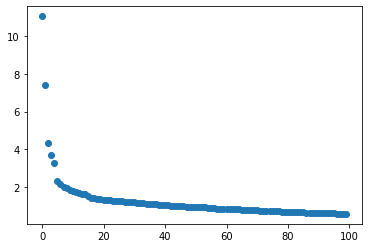

In [78]:
pyplot.plot(svd.explained_variance_, 'o')

In [ ]:
# 해당 차원의 개수일 때 설명하는 정도 

### 차원 축소

In [79]:
x_test.shape

(6978, 2000)

In [80]:
doc_emb = svd.transform(x_test)

In [81]:
doc_emb.shape

(6978, 100)

### 주제 보기

In [82]:
svd.components_.shape

(100, 2000)

In [83]:
loading = pd.DataFrame(svd.components_.T) # components는 svd를 실행한 결과에서 컬럼에 대한 주제확률 의미한다. 이때 모든 값은 양수  
# components_의 값은 열값(여기서는 단어를 의미)을 우리가 지정한 값의 개수만큼으로 늘려 값 변환시킨것. 

In [84]:
loading['word'] = cv.get_feature_names()

In [85]:
i = 0
loading.sort_values(i, ascending=False).loc[:, [i, 'word']].head()
# 0번째 축에 들어간 단어들을 의미한다. 해당 방향으로 바뀌엇음을 의미. 

,0,word
1797,0.190082,tells
636,0.184727,father
850,0.143918,house
838,0.143609,home
1110,0.135895,man


## Non-negative Matrix Factorization

In [86]:
from sklearn.decomposition import NMF

In [87]:
nmf = NMF(n_components=20, random_state=1234)
nmf.fit(x_train)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=20, random_state=1234, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

### 주제 보기

In [88]:
loading = pd.DataFrame(nmf.components_.T)

In [89]:
loading['word'] = cv.get_feature_names()

In [95]:
i = 4
loading.sort_values(i, ascending=False).loc[:, [i, 'word']].head(10)

,4,word
636,20.066040,father
1188,6.176156,mother
1668,3.595992,son
440,1.769520,daughter
215,1.082621,boy
838,1.054069,home
316,1.031064,child
451,0.991239,death
1251,0.748907,old
1023,0.728728,later


In [96]:
emb = nmf.transform(x_test)

In [97]:
sorted(list(enumerate(emb[0])), key=lambda x: x[1], reverse=True)
# 해당 차원의 좌표를 의미한다. -> 5번 차원에 대하여 확인하고 해당 장르라 해석하면 된다. 

[(5, 0.15739583196748802),
 (11, 0.06405412059142378),
 (7, 0.055600047668369984),
 (4, 0.04713942200608705),
 (13, 0.02936863750661348),
 (0, 0.0041040657845773055),
 (12, 0.0011513740593924533),
 (1, 0.0),
 (2, 0.0),
 (3, 0.0),
 (6, 0.0),
 (8, 0.0),
 (9, 0.0),
 (10, 0.0),
 (14, 0.0),
 (15, 0.0),
 (16, 0.0),
 (17, 0.0),
 (18, 0.0),
 (19, 0.0)]

In [98]:
i = 5
loading.sort_values(i, ascending=False).loc[:, [i, 'word']].head(10)

,5,word
1151,4.746426,men
986,3.824056,killed
767,3.338384,group
589,3.267987,escape
985,3.257324,kill
1621,2.963989,ship
992,2.874034,king
129,2.562178,attack
989,2.498459,kills
451,2.462237,death
